# Homework #8: Due November 4th, 2021, 11:59pm
## Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
            if reg_param is None:
                sum_error = np.sum(squared_error)
                return sum_error
            else:
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

## Problem Description: Bayesian Neural Network Regression
In this homework you will explore Bayeisan models for regression with neural networks -- essentially, you will place priors on the network parameters $\mathbf{W}$ and infer the posterior $p(\mathbf{W}|\text{Data})$. These Bayesian models are called ***Bayesian neural networks***. The data for this regression problem is in `HW8_data.csv`. You are provided an implementation of a neural network as well as an example of how to use it -- but feel free to implement your own version!

In [4]:
#read in the data
data = pd.read_csv('HW8_data.csv')
x_train = data['x'].values.reshape((1, -1))
y_train = data['y'].values.reshape((1, -1))
data.head()

,x,y
0,-6.0,-3.380284
1,-5.6,-2.892117
2,-5.2,-2.690059
3,-4.8,-2.040000
4,-4.4,-1.399942


Let's instantiate a neural network with 1-hidden layer, 5-hidden nodes and `relu` activation:

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

Fit the neural network to the data and visualize the fit.

In [6]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x_train, y_train, params)

Iteration 0 lower bound 1188.2522119587577; gradient mag: 3294.9472005145494
Iteration 100 lower bound 528.2005162282458; gradient mag: 2014.0223481861012
Iteration 200 lower bound 231.71928757081068; gradient mag: 1226.9831178661013
Iteration 300 lower bound 103.99541756891784; gradient mag: 716.7107003654073
Iteration 400 lower bound 55.24716113156889; gradient mag: 376.23346335998286
Iteration 500 lower bound 39.94989749994618; gradient mag: 177.9641773056736
Iteration 600 lower bound 35.60307206137053; gradient mag: 77.19358484414678
Iteration 700 lower bound 34.025856107542445; gradient mag: 38.67687513287844
Iteration 800 lower bound 32.961429361488406; gradient mag: 31.129490339137103
Iteration 900 lower bound 31.989641942996613; gradient mag: 24.752496721932584
Iteration 1000 lower bound 31.082564536611727; gradient mag: 24.616299563320247
Iteration 1100 lower bound 30.155032233758106; gradient mag: 24.248289796695595
Iteration 1200 lower bound 29.210013809597285; gradient mag:

Iteration 10600 lower bound 2.433316490178128; gradient mag: 0.767066193236975
Iteration 10700 lower bound 2.376555349336703; gradient mag: 0.7553579421583901
Iteration 10800 lower bound 2.3238459422563476; gradient mag: 0.7228024683428217
Iteration 10900 lower bound 2.275330834330171; gradient mag: 0.6845211470546975
Iteration 11000 lower bound 2.231249650994422; gradient mag: 0.6413826587052399
Iteration 11100 lower bound 2.191827804434735; gradient mag: 0.5943225261135897
Iteration 11200 lower bound 2.1572058127250573; gradient mag: 0.5444130874954253
Iteration 11300 lower bound 2.1273989093957457; gradient mag: 0.49279021686790947
Iteration 11400 lower bound 2.1022813532268936; gradient mag: 0.44060151668110925
Iteration 11500 lower bound 2.0815910694099786; gradient mag: 0.38895956298850276
Iteration 11600 lower bound 2.0649500999980592; gradient mag: 0.33889610830749123
Iteration 11700 lower bound 2.0518957709682137; gradient mag: 0.2913192491317288
Iteration 11800 lower bound 2.

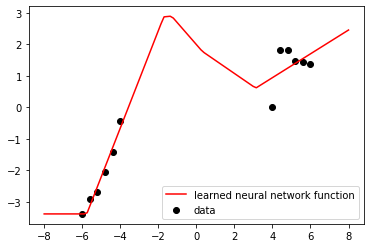

In [7]:
#test x-values
x_test = np.linspace(-8, 8, 100).reshape((1, -1))
#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)
#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

### Part I: Inference for Bayesian Neural Networks Using HMC

1. (**The Bayesian Neural Network Model**) We will implement the following Bayesian model for the data:<br>
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)\\
\end{align}
where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases).
<br><br>
Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.

2. (**Sample from the Posterior**) Use HMC to sample from the posterior of the Bayesian neural network in Exercise 1 with 1 hidden layer and 5 hidden nodes. Start with the following settings for your sampler:
``` python
params = {'step_size':1e-3, 
          'leapfrog_steps':50, 
          'total_samples':10000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights}
```
  Note that you should initialize with the MLE model, otherwise convergence may be slow. Please feel free to tweak these design choices as you see fit!

3. (**Visualize the Posterior Predictive**) Visualize 100 samples, randomly selected, from your posterior samples of $\mathbf{W}$, by ploting their predicted values plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)
```
  where `sample` is a posterior sample of $\mathbf{W}$.

4. (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

### Part II: Inference for BNNs Using Black-Box Variational Inference with the Reparametrization Trick

1. (**BBVI with the Reparametrization Trick**) Implement BBVI with the reparametrization trick for approximating an arbitrary posterior $p(w| \text{Data})$ by an isotropic Gaussian $\mathcal{N}(\mu, \Sigma)$, where $\Sigma$ is a diagonal matrix. See Lecture #17 or the example code from [autograd's github repo](https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py). 

    **Unit Test:** You shoud check that your implementation is correct by approximating the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

  The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):
<img src="./logistic_posterior.png" style='height:200px;'>
  Your mean-field variational approximation should be a Gaussian with mean around -0.321 and standard deviation around 0.876.

2. (**Variational Inference for BNNs**) For the Bayesian model you implemented in Exercise 1 and 2, use BBVI with the reparametrization trick to approximate the posterior of the Bayesian neural network with a mean-field Gaussian variational family (i.e. an isotropic Gaussian). Please set learning rate and maximum iteration choices as you see fit!

3. (**Visualize the Posterior Predictive**) Visualize 100 samples $\mathbf{W}^s$ from your approximate posterior of $\mathbf{W}$ by ploting the neural network outputs with weight $\mathbf{W}^s$ plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)
```
  where `sample` is a sample from the approximate posterior of $\mathbf{W}$.

4.  (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

### Part III: Comparison 

1. (**Model Evaluation**) Compare the posterior predictive visualization from BBVI with the reparametrization trick to the one you obtained using HMC. Can you say whether or not your posterior approximation is good? How does approximating the posterior effect our estimation of epistemic and aleatoric uncertainty?

2. (**Quality of Posterior Vs Quality of Posterior Predictive**) Based on your convergence diagnostics of your HMC sampler, do you believe that you've obtained a set of representative samples from the BNN posterior? Why or why not? 

  Based on your understanding of BNN posteriors, do you believe that a mean-field Gaussian is a good approximation of the BNN posterior? Why or why not?

  Which set of samples, HMC or VI, do you believe better captures the BNN posterior?

  Based on the empirical results from above, do you believe there is a clear positive relationship between posterior approximation and quality of posterior predictive uncertainties - i.e. is it true that the more I capture of the BNN posterior the beter the quality of my posterior predictive uncertainties?

3. (**Speed and Scalability**) Compare the two inference methods, HMC and BBVI, and discuss the scalability of each with respect to the number of model parameters and number of data points (how does increasing the number of model parameters or the number of data points affect each inference method?). 